# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**: Jiaming Yuan (jy729)

**ID**: 5393613

> **Due Date**
>
> Wednesday, 9/25/24, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [60]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/Programming/Julia/BEE4750/labs/lab2-jiamingy5`


In [61]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Overview

In this lab, we will use Monte Carlo analysis to analyze a version of
the culmination of every episode of the long-running game show [The
Price Is Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

In [82]:
Random.seed!(1)

TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [63]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 ⋮
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

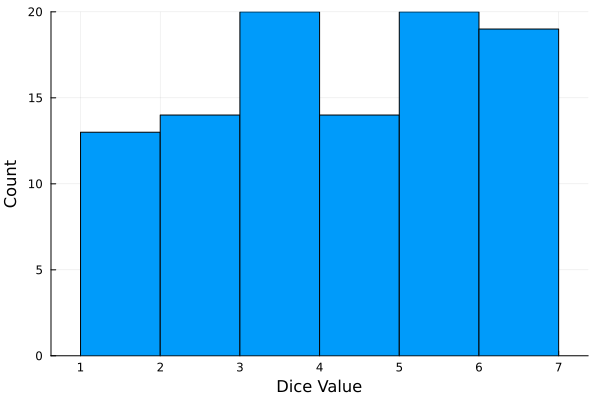

In [64]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

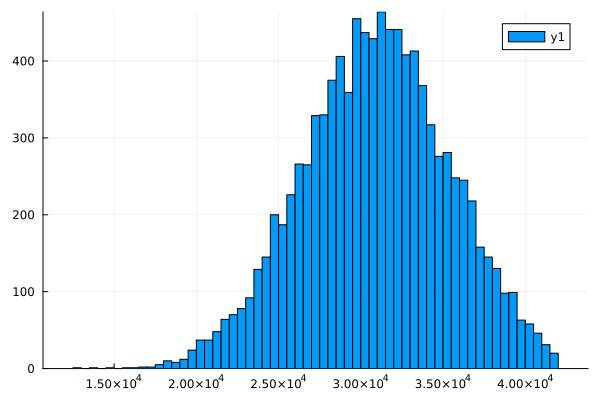

In [65]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10_000)
histogram(showcase_samples)

Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

### Lab Writeup

To run the Monte Carlo experiment, I first wrote a function that would run one simulation of the game. The inputs are the bid value (a constant $35000 in this case) and the number of random samples to feed the model. To sample, I used the rand function to randomly sample from the showcase distribution based on how many samples were desired from the input. In this case, I used 5000 because larger samples are better, but too large will be computationally costly.

Then, the model tests each of the three outcomes (overbid, wins both showcases, wins one showcase) and calculates the expected earning depending on which outcome results from the $35000 bid. If it's an overbid, the earning is $0; for both showcases, the earnings is 2 times the current showcase price; and if they don't win both showcases, first we calculate the probability that they lose the showcase (which is proportional to the difference between the showcase price and the bid) and then multiply the probability they win the bid by the showcase price. Finally, in all three scenarios, we add the earnings from that round to the total earned in the simulation.

The simulation is then repeated 5000 times. Since each simulation has 5000 runs, I take an average of each run as the probability of achieving this earning value. Finally, I plotted the vector of 50000 averages (results) to see how the expected value is changing as the number of samples increases. The plot I produced has the right shape--it starts off oscillating greatly and then converges to a single value as the sample size increases--although the value it converges on is probably not right. 

7.149812443466495e6

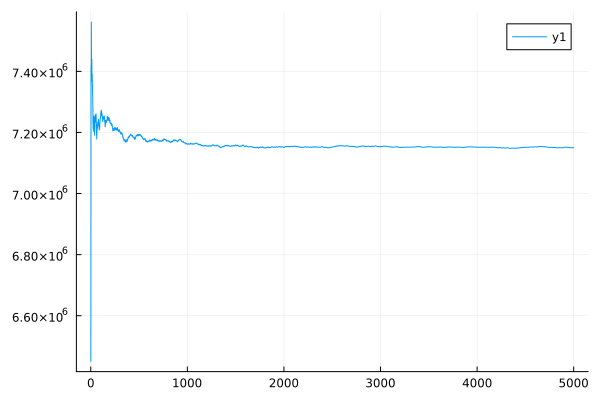

In [85]:
#Code for lab
bid = 35000

function simulation(bid, num_samples)
    running_est = 0
    samples = rand(showcase_dist, num_samples)
    for i in 1:length(samples)
        if bid > samples[i]
            earnings = 0
            running_est = running_est + earnings
        elseif abs(bid-samples[i]) < 250
            earnings = 2*samples[i]
            running_est = running_est + earnings
        else
            probab_lose = 1 - (samples[i]-bid)/samples[i]
            earnings = (1 - probab_lose)*samples[i]
            running_est = running_est + earnings
        end
    end
    return running_est
end

x = 5000
expect_wins = zeros(x)
average = zeros(x)
for i in 1:x
    expect_wins[i] = simulation(bid, x)
    average[i] = sum(expect_wins[1:i])/i
end
iterations = range(1,x)

display(average[x])
plot(iterations, average,show=true)



## References

Put any consulted sources here, including classmates you worked with/who
helped you.


I talked about interpreting the problem setup with Ari and Grace. 
